Tools for grading and analyzing student journals

In [1]:
%cd ~/Dropbox/CanvasTools

import environment
import os
import sys
import configparser
import requests
import json
import docx
import PyPDF2
  
#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


# Load api token and section numbers
print("Reading credentials from %s" % environment.CREDENTIALS_FILE)
config = configparser.ConfigParser()
config.read( environment.CREDENTIALS_FILE)

SECTION_930 = config['sections'].getint('930')
SECTION_1100 = config['sections'].getint('1100')
SECTION_1230 = config['sections'].getint('1230')
URL_BASE = config['url'].get('BASE')

sections = [SECTION_930, SECTION_1100, SECTION_1230]

/Users/adam/Dropbox/CanvasTools
Reading credentials and settingsfrom /Users/adam/Dropbox/CanvasTools/private/canvas-credentials.ini
Reading credentials from /Users/adam/Dropbox/CanvasTools/private/canvas-credentials.ini


In [2]:
from CanvasTools.UrlTools import make_url
from CanvasTools.RequestTools import send_get_request, make_request_header, get_all_course_assignments
from CanvasTools.FileTools import makeDataFileIterator

In [ ]:
# Determine which need grading
def get_assignments_needing_grading(course_id):
    """Returns a list of tuples (name, id) of assignments which
    have ungraded submissions"""
    assigns = get_all_course_assignments(course_id)
    to_grade = [a for a in assigns if a['needs_grading_count'] >0]

    to_grade = [( g['name'].strip(), g['id']) for g in to_grade]
    return to_grade

In [ ]:
get_assignments_needing_grading(SECTION_930)

In [ ]:
sections

# Prepare archive folder to save ungraded journals

In [ ]:
def journal_folder_name(journal_name, course_id):
    """Creates a folder to store student work for the assignment"""
    folder_name = journal_name.replace('(', '').replace(')', '').replace(' ', '-')
    return "%s/%s-%s" % (environment.ARCHIVE_FOLDER, course_id, folder_name)

def create_folder(folder_path):
    try:
        os.mkdir(folder_path)
    except:
        pass

# journal_folder = journal_folder_name(to_grade[0][1], SECTION_1100)
# journal_folder

In [ ]:
# %cd {environment.ARCHIVE_FOLDER}
# for f in to_grade:
#     journal_folder = journal_folder_name(f[1])
#     %mkdir {journal_folder}
# # back to the root
# %cd {environment.PROJ_BASE}

 # Download all submissions of the assignment

    GET /api/v1/courses/:course_id/assignments/:assignment_id/submissions/:user_id 
    
  
  ToDo
  
      - Consider using the pagination rather than setting a fixed count (The pagination is here: response.links)

In [ ]:
def download_journals(url, destination):
    # download file
    print(url)
    file_response = requests.get(url, headers=make_request_header())

    # write to folder
    print("Writing to %s" % destination)
    open(destination, 'wb').write(file_response.content)

def make_journal_filename(response):
    return "%s-%s" % (response['user_id'], response['attachments'][0]['filename'] )


def getDocxText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)

    return '\n'.join(fullText)

def getPdfText(filepath):
    pdfFileObj = open(filepath, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    pageObj = pdfReader.getPage(0)
    return pageObj.extractText()

def getBody(filepath):
    """Extracts the text from a saved file"""
    PICTURE_PLACEHOLDER = 'picture-uploaded picture-uploaded picture-uploaded picture-uploaded picture-uploaded'
    filepath = filepath.strip()
    
    if filepath[-5:] == '.docx':
        return getDocxText(filepath)

    if filepath[-4:] == '.pdf':
        return getPdfText(filepath)

    elif filepath[-4:] == '.jpg':
        return PICTURE_PLACEHOLDER

    elif filepath[-4:] == '.png':
        return  PICTURE_PLACEHOLDER
    
    elif filepath[-4:] == '.xml':
        return  PICTURE_PLACEHOLDER
        
    elif filepath[-6:] == '.pages':
        return  PICTURE_PLACEHOLDER
    
    elif filepath[-4:] == '.odt':
        return  PICTURE_PLACEHOLDER
    
    else:
        return  PICTURE_PLACEHOLDER


def download_submitted_file(url, filepath):
    response = requests.get(url, headers=make_request_header())
    # save it to file
    open(filepath, 'wb').write(response.content)


def get_submissions(course_id, assignment_id, per_page=42):
    """Makes request to the server for all submissions for the given assignment"""
    url = make_url(course_id, 'assignments')
    url = "%s/%s/submissions?per_page=%s" % (url, assignment_id, per_page)
    print(url)
    response2 = requests.get(url, headers=make_request_header())
    return response2

def process_response(response, journal_folder):
    """Takes the response and pulls out submissions which used the text box, then downloads
    submitted files and processes out their text content
    """
    submissions = []

    for j in response.json():
        result = {'submission_id' : j['id'], 'student_id': j['user_id']}
        if j['body'] is not None:
            # The student used the online text box to submit
            result['body'] = j['body']

        else:
            # The student submitted the journal as a separate document
            if 'attachments' in j.keys() and len(j['attachments']) > 0:
                url = j['attachments'][0]['url']
                filename = make_journal_filename(j)
                
                # download and save submitted file
                fpath = "%s/%s" % (journal_folder, filename)
                download_submitted_file(url, fpath)
                
                # open the file and extract text
                result['body'] = getBody(fpath)

            else:
                # NB., if a student never submitted (workflow_state = 'unsubmitted'),
                # then they will have an entry which lacks a body key
                result['body'] = None
        submissions.append(result)
    
    return submissions


def save_submission_json(submissions, folder):
    # save submissions
    with open("%s/all-submissions.json" % folder, 'w') as fpp:
        json.dump(submissions, fpp)

In [ ]:
course_id = SECTION_930
assignment_id = 288480

response2 = get_submissions(course_id, assignment_id)

In [ ]:
len(response2.json())

In [ ]:
response2.links

In [ ]:
len(submissions)

In [ ]:
submissions

In [ ]:
for s in submissions:
    print(s['student_id'], s['body'])

# Detect any empty journals

In [ ]:
def determine_credit(submissions):
    credit = []
    nocredit = []

    for s in submissions:
        if 'body' in s.keys() and s['body'] is not None and len(s['body']) > 2:
            credit.append(s['student_id'])
        else:
            nocredit.append(s['student_id'])
    
    return {'credit': credit, 'nocredit': nocredit}
    

In [ ]:
credit

In [ ]:
nocredit

# Upload grades 

 PUT /api/v1/courses/:course_id/assignments/:assignment_id/submissions/:user_id 

In [ ]:
def assign_credit(course_id, assignment_id, students):
    """Makes the requests to the server to assign each of the students credit
    for the assignment
    """
    data = {'submission' : {'posted_grade' : 'pass'}} 

    url = make_url(course_id, 'assignments')
    url = "%s/%s/submissions" % (url, assignment_id)

    for s in students:
        surl = "%s/%s" % (url, s)
        print('credit', surl)
        requests.put(surl, headers=make_request_header(), json=data)

def assign_no_credit(course_id, assignment_id, students):
    """Makes the requests to the server to assign each of the students no credit
    for the assignment
    """
    data = {'submission' : {'posted_grade' : 'fail'}} 

    url = make_url(course_id, 'assignments')
    url = "%s/%s/submissions" % (url, assignment_id)

    for s in students:
        surl = "%s/%s" % (url, s)
        print('no credit', surl)
#         requests.put(surl, headers=make_request_header(), json=data)


In [ ]:
# data = {'submission' : {'posted_grade' : 'pass'}} 

# u = 'https://canvas.csun.edu/api/v1/courses/41179/assignments/288479/submissions/13099'
# requests.put(u, headers=make_request_header(), json=data)


In [ ]:
# Master: Downloads all assignments which need grading and 
# determines whether to give them credit

credit = []
nocredit = []

for course_id in sections:
    to_grade = get_assignments_needing_grading(course_id)
    
    for name, assignment_id in to_grade:
        # make folder
        folder = journal_folder_name(name, course_id)
        create_folder(folder)
        # download student submissions 
        response = get_submissions(course_id, assignment_id)
        submissions = process_response(response, folder)
        # save a copy 
        save_submission_json(submissions, folder)
        # give credit for non-empty submissions
        c = determine_credit(submissions)
        # store the decisions rather than sending to server
        # that way we don't keep updating until ready
        credit.append({'course' : course_id, 'assignment': assignment_id, 'ids': c['credit']})
        nocredit.append({'course' : course_id, 'assignment': assignment_id, 'ids': c['nocredit']})

#         assign_credit(course_id, assignment_id, c['credit'])
#         assign_no_credit(course_id, assignment_id, c['nocredit'])

In [ ]:
for c in credit:
    course_id = c['course']
    assign_id = c['assignment']
    assign_credit(course_id, assign_id, c['ids'])


In [ ]:
nocredit

In [ ]:
submissions

# Plot wordcount distributions

In [3]:
START_WEEK = 2
STOP_WEEK = 4
DATA_FOLDER = '%s/data' % environment.PROJ_BASE
IGNORE_FILE = "%s/ignore.csv" % DATA_FOLDER

from CanvasTools.TextProcessing import make_wordbag
from CanvasTools.TextProcessing import WordFreq as WF

## Load data

In [4]:
def week_key_gen(start=START_WEEK, stop=STOP_WEEK +1):
    """Create an iterator for all the keys to the various dictionaries"""
    for i in range(start, stop):
        yield "w%s" % i


In [5]:
# Get all subfolder paths

import os

def get_journal_folders():
    """Constructs paths to all journal folders and returns the list
        example result: [
            '/Users/adam/Box Sync/Phil 305 Business ethics/Student work/41181-Journal-week-2',
             '/Users/adam/Box Sync/Phil 305 Business ethics/Student work/41181-Journal-week-3',
             ....
    """
    journal_folders = []
    for root, dirs, files in os.walk(environment.ARCHIVE_FOLDER):
        for d in dirs:
            journal_folders.append(os.path.join(root, d)) 
    return journal_folders


def make_folder_list(sections, week_num):
    return ["%s-Journal-week-%s" % (s, week_num) for s in sections]


# counts from each week
def calculate_journal_counts(journal_folders):
    """Returns the count of journals for each week"""
    cnt = []
    for r in journal_folders:
        with open("%s/all-submissions.json" % r, 'r') as f:
            j = json.load(f)
        cnt.append((r.split('/')[-1:], len(j)))
    return cnt

In [6]:
def load_words_to_ignore(file=IGNORE_FILE):
    words = []
    with open(file, 'r') as csvfile:
        reader = csv.DictReader(csvfile) #, delimiter=',', quotechar='|')
        for row in reader:
#             print (row['journals'])
            words.append(row['journals'])
    return words

In [14]:
def filter_out_terms(combined):
    """Loads the strings to ignore from IGNORE_FILE and returns the filtered wordbag"""
    exclude = load_words_to_ignore()
#     exclude = ['/p','style=', 'br', '“', 'ethics', '”', 'm','’','p', 'picture-uploaded', 'div', '/div',
#               '305', 'september', '2018', 'text-align', 'class=', 'span', 'swenson', 'phil', 'philosophy', 
#                '-webkit-standard', 'font', 'face='
#               ]
    exclude += [ "%s" % i for i in range(0,10)]
#     print(exclude)

    for k in combined.keys():
        combined[k] = [w for w in combined[k] if w not in exclude]
    return combined

In [8]:
import csv
def write_csv( csvFile, rowsToWrite ):
    """TODO: let this figure out whether needs i, j or i"""
    with open( csvFile, 'a' ) as csvfile:
        writer = csv.writer( csvfile )
        # for i in toWrite:
        if type(rowsToWrite) is not list:
            rowsToWrite = [rowsToWrite]
        for r in rowsToWrite:
            print(r)
            writer.writerow(  r  )



In [9]:

def clearplot_function( ):
    """Clears the matplotlib plot to free system resources. Call in next cell after plot"""
    try:
        plt.close( plt.gcf( ) ); plt.close( 'all' )
    except:
        pass



In [ ]:
exclude = ['/p','style=', 'br', '“', 'ethics', '”', 'm','’','p', 'picture-uploaded', 'div', '/div',
              '305', 'september', '2018', 'text-align', 'class=', 'span', 'swenson', 'phil', 'philosophy', 
               '-webkit-standard', 'font', 'face='
              ]

In [ ]:
# Create the file of terms to ignore
with open(IGNORE_FILE, 'w') as csvfile:
    fieldnames = ['journals', 'online_assignments']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for e in exclude:
        writer.writerow({'journals': e, 'online_assignments': ''})


In [ ]:
load_words_to_ignore()

In [10]:
journal_folders = get_journal_folders()

In [11]:
wcnt = calculate_journal_counts(journal_folders)
wcnt   

[(['41181-Journal-week-2'], 35),
 (['41181-Journal-week-3'], 35),
 (['41181-Journal-week-4'], 35),
 (['41180-Journal-week-4'], 41),
 (['41180-Journal-week-3'], 41),
 (['41180-Journal-week-2'], 41)]

In [15]:
# Load all content as wordbags

data = {}
for r in journal_folders:
    with open("%s/all-submissions.json" % r, 'r') as f:
        j = json.load(f)
    data[r.split('/')[-1:][0]] = [make_wordbag(str(row['body'])) for row in j]

# data

In [16]:
combined = {}
"""word bags containing all words from all courses for the week
has the format {'w2' : [], 'w3': [], 'w4' : []}"""


freqs = {}
"""contains a word frequency object for each week"""

w = START_WEEK

while w <= STOP_WEEK:
    folders = make_folder_list(sections, w)
    # add entry to the output dict
    key = 'w%s' % w
    combined[key] = []
    for k in folders:
        if k in data.keys():
            for b in data[k]:
                combined[key] += b
    w += 1

# Run filters on the combined wordbags
combined = filter_out_terms(combined)

# populate the dictionary with frequencies
for k in combined.keys():
    freqs[k] = WF(combined[k])



## Unigram visualizations

In [17]:
import wordcloud

def draw_cloud(wordlist, title, font_size=20):
    """Given a list of words, it plots a wordcloud"""
    # make into block of text
    words = ' '.join(combined['w4'])

    wc = wordcloud.WordCloud(
                          width=2500,
                          height=2000
                         ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    ax = plt.gca()
    ax.title.set_fontsize(font_size)
    plt.show()

def draw_cloud_from_freqs(freqs, week_num, title, font_size=20):
    """Given the frequency object with keys like w1, w2,
    this plots a wordcloud from those frequencies
    """
    f = {}
    w = "w%s" % week_num
    for k in freqs[w].freqDist:
        f[k] = freqs[w].freqDist.freq(k)
  
    wc = wordcloud.WordCloud(width=2500, height=2000).generate_from_frequencies(f)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    ax = plt.gca()
    ax.title.set_fontsize(font_size)
    plt.show()

def draw_cumulative_freq(freqs, week_num, max_terms=30, font_size=20):
    """Plots cumulative frequencies of terms"""
    week = "w%s" % week_num

    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(week)
    
#     # rotate the x axis labels to 45 degrees
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)


    fig.set_figwidth(13)
    fig.set_figheight(5)
    # change the font size
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size)
    
    plt.xticks(rotation=45)


    freqs[week].plot(max_terms)
    fig.tight_layout()


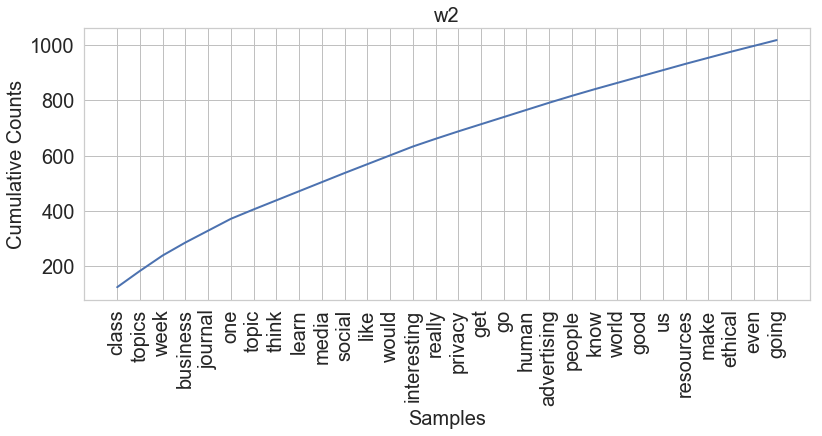

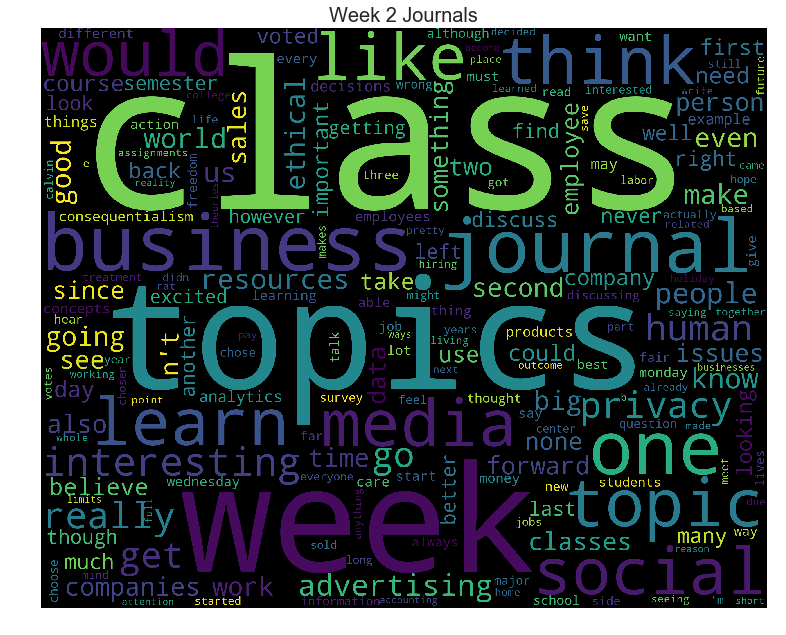

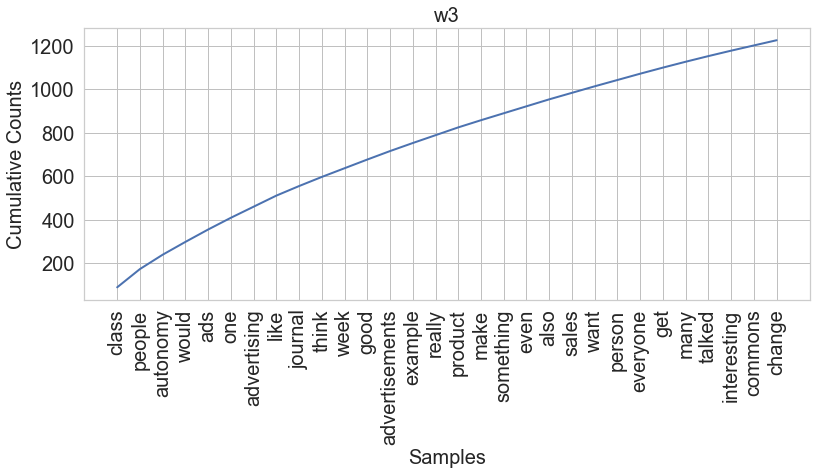

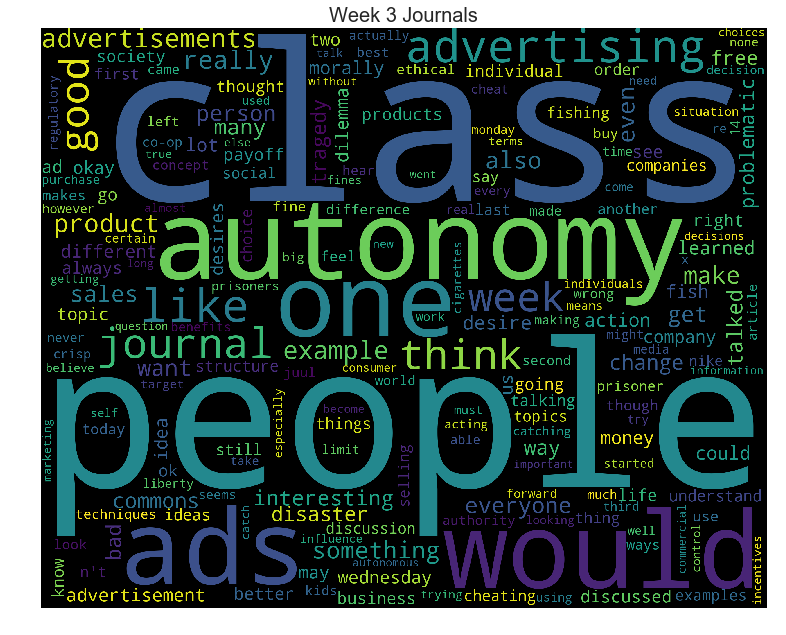

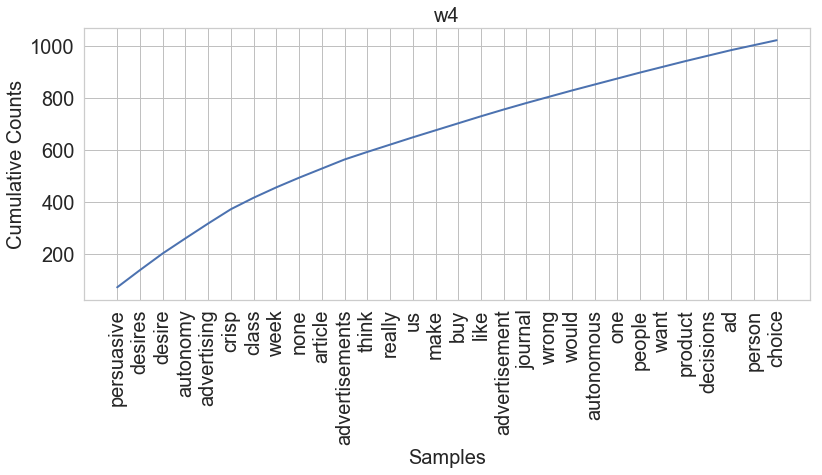

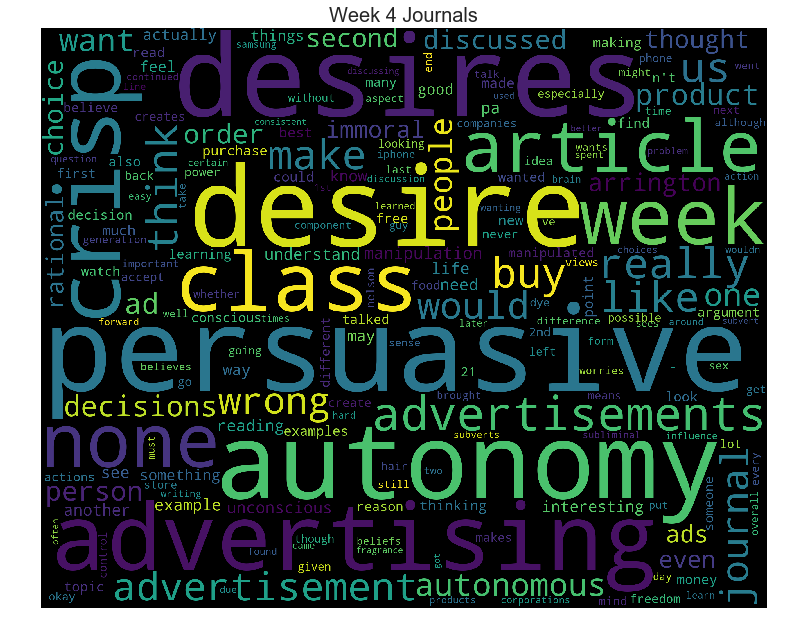

In [18]:

# while True:
for i in range(START_WEEK, STOP_WEEK +1):
    # plot the cumulative frequencies
    draw_cumulative_freq(freqs, i)
    w = "w%s" % i
    # plot the wordcloud
    draw_cloud_from_freqs(freqs, i, 'Week %s Journals' % i)
#     draw_cloud(combined[w], 'week %s journals' % i)
    

## Ngram tools

In [19]:
"""
Previously in TextProcessingTools
Created by adam on 11/11/15
"""
__author__ = 'adam'

import nltk

# This idiom is necessary. See https://github.com/nltk/nltk/issues/1516
from nltk.metrics import association



class NgramError(BaseException):
    def __init__(self, processing_step):
        """
        Arguments:
            :param processing_step: String description of where error arose
        :return:
        """
        super().__init__()
        self.kind = 'NgramProcessing'
        self.identifier_type = 'String content'
        self.step = processing_step
#         ProcessingError.__init__(self, processing_step)

class NgramGetter(object):
    """
    Abstract parent class for extracting ngrams.

    Attributes:
        collocation_finder: One of the nltk's collocation finder tools (e.g., BigramCollocationFinder)
        top_likelihood_ratio:
        measurement_tool: One of nltk's measurement tools (e.g., nltk.collocations.BigramAssocMeasures)
        modifiers: IModifier instantiating tool for modifying the text before calculating ngrams
        ngrams: List of ngrams
        raw_freq: Frequency distribution of ngrams
        sorted_ngrams: List of tuples sorted by self.scored_ngrams
        top_pmi: Variable number of n-grams with the highest Pointwise Mutual Information (i.e., which occur together
        more often than would be expected)
        word_bag: List of text to run
    """

    def __init__(self):
        self.modifiers = []
        self.ngram_filters = []
        self.word_bag = []
        self.ngrams = []
        if not self.measurement_tool:
            raise NotImplementedError

    def add_modifier(self, iModifier):
        assert(isinstance(iModifier, IModifier))
        self.modifiers.append(iModifier)

    def _run_modifiers(self):
        """
        Calls the modifiers in sequence and stores the results back in word_bag
        """
        for modifier in self.modifiers:
            self.word_bag = [modifier.process(w) for w in self.word_bag]

    def add_filter(self, iNgramFilter):
        """
        Adds a filter to be run after the ngrams are created
        :param iNgramFilter:
        :return:
        """
        self.ngram_filters.append(iNgramFilter)

    def apply_filters(self):
        for ftr in self.ngram_filters:
            self.collocation_finder.apply_ngram_filter(ftr)

    def process(self, word_bag, min_freq=3, get_top=10, **kwargs):
        """
        Runs any modifiers (stemmers, lemmatizers, etc) on the list of terms and
        then extracts the ngrams

        Args:
            get_top: The cut off for ngrams to get stats for
            min_freq: Integer of minimum number of appearances of ngram to extract
            word_bag: List of strings to extract ngrams from. Should already be filtered.
        """
        raise NotImplementedError

    def _calculate_statistics(self, get_top=10, **kwargs):
        """
                A number of measures are available to score collocations or other associations.
        The arguments to measure functions are marginals of a contingency table,
        in the bigram case (n_ii, (n_ix, n_xi), n_xx):
                w1    ~w1
             ------ ------
         w2 | n_ii | n_oi | = n_xi
             ------ ------
        ~w2 | n_io | n_oo |
             ------ ------
             = n_ix        TOTAL = n_xx
        We test their calculation using some known values presented
        in Manning and Schutze's text and other papers.
        Student's t: examples from Manning and Schutze 5.3.2
        Arguments:
            get_top: The cut off for ngrams to get stats for
        """
        self.topPMI = self.collocation_finder.nbest(self.measurement_tool.pmi, get_top)
        self.raw_freq = self.collocation_finder.score_ngrams(self.measurement_tool.raw_freq)
        self.sorted_ngrams = [ngram for ngram, score in self.raw_freq]
        self.top_likelihood_ratio = self.collocation_finder.nbest(self.measurement_tool.likelihood_ratio, get_top)


class BigramGetter(NgramGetter):
    """
    Extracts 2-grams from a word bag and calculates statistics
    Attributes:
        top_pmi: Variable number of n-grams with the highest Pointwise Mutual Information (i.e., which occur together
        more often than would be expected)
        top_likelihood_ratio:
        raw_freq: Frequency distribution of ngrams
        sorted_ngrams: List of tuples sorted by self.scored_ngrams
    """

    def __init__(self):
        self.measurement_tool = association.BigramAssocMeasures()
        NgramGetter.__init__(self)

    def process(self, word_bag, min_freq=3, get_top=10, **kwargs):
        """
        Arguments:
            word_bag: List of strings
        """
        assert(isinstance(word_bag, list))
        self.collocation_finder = nltk.collocations.BigramCollocationFinder.from_words(word_bag)
        self.collocation_finder.apply_freq_filter(min_freq)
        self._calculate_statistics(get_top)

class TrigramGetter(NgramGetter):
    """
        Extracts 3-grams from a word bag and calculates statistics
    """

    def __init__(self):
        self.measurement_tool = association.TrigramAssocMeasures()
        NgramGetter.__init__(self)

    def process(self, word_bag, min_freq=3, get_top=10, **kwargs):
        """
        Arguments:
            word_bag: List of strings
        """
        assert(isinstance(word_bag, list))
#         try:
        self._run_modifiers()
        self.collocation_finder = nltk.collocations.TrigramCollocationFinder.from_words(word_bag)
        self.collocation_finder.apply_freq_filter(min_freq)
        self._calculate_statistics(get_top)


### Find bigrams

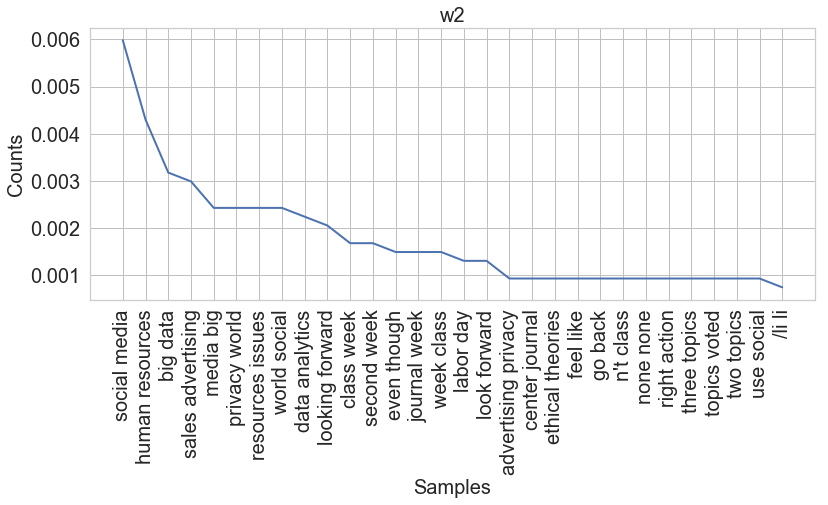

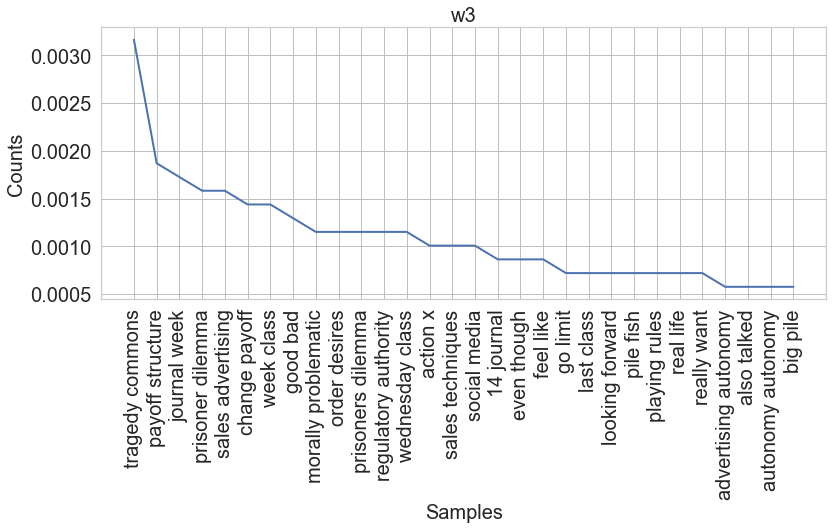

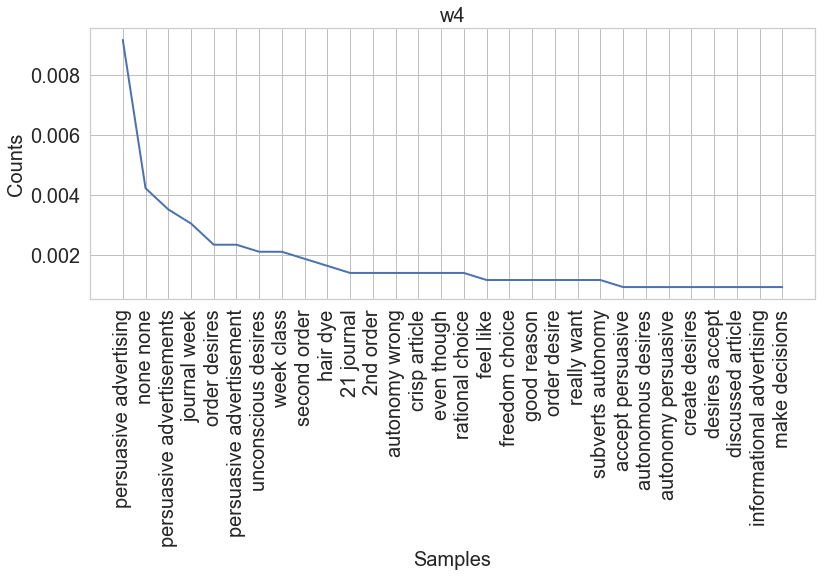

In [20]:
from nltk.probability import FreqDist

bigrams = {}
week_iter = week_key_gen()
i = START_WEEK

while True:
    try:
        w = next(week_iter)
        
        bg = BigramGetter()
        bg.process(combined[w])
        #store the bigram object in our dict
        bigrams[w] = bg

        # reshape into a usable form for plotting
        fs = FreqDist()
        for s, freq in bg.raw_freq:
            # make the string key and set the frequency
            fs["%s %s" % (s[0], s[1])] = freq

        # plot the cumulative frequencies
        draw_cumulative_freq({w : fs}, i)
        
        i += 1
    except StopIteration:
        break

In [21]:
clearplot_function()

### Likelihood ratio

In [30]:
# Print top likelihood ratio
def print_top_likelihood_ratios(ngrams):
    week_iter = week_key_gen()

    while True:
        try:
            week = next(week_iter)
            print(week)
            [print(b) for b in ngrams[week].top_likelihood_ratio]
        except StopIteration:
            break

def print_top_PMI(ngrams):
    week_iter = week_key_gen()
    print("Top PMI")

    while True:
        try:
            week = next(week_iter)
            print(week)
            [print(b) for b in ngrams[week].topPMI]
        except StopIteration:
            break


In [26]:
print_top_likelihood_ratios(bigrams)

w2
('social', 'media')
('human', 'resources')
('big', 'data')
('sales', 'advertising')
('data', 'analytics')
('resources', 'issues')
('looking', 'forward')
('privacy', 'world')
('media', 'big')
('world', 'social')
w3
('tragedy', 'commons')
('payoff', 'structure')
('prisoner', 'dilemma')
('regulatory', 'authority')
('change', 'payoff')
('prisoners', 'dilemma')
('social', 'media')
('order', 'desires')
('journal', 'week')
('action', 'x')
w4
('persuasive', 'advertising')
('none', 'none')
('hair', 'dye')
('journal', 'week')
('persuasive', 'advertisements')
('second', 'order')
('even', 'though')
('order', 'desires')
('unconscious', 'desires')
('2nd', 'order')


In [31]:
print_top_PMI(bigrams)

Top PMI
w2
('across', 'board')
('fairness', 'justice')
("42'5", '4+')
('/li', 'li')
('minimum', 'wage')
('makes', 'sense')
('community', 'college')
('c', 'b')
('concepts', 'fairness')
('labor', 'day')
w3
('colin', 'kaepernick')
('tax', 'breaks')
('years', 'prison')
('younger', 'generation')
('robber', 'wallet')
('playing', 'rules')
('acting', 'freely')
('third', 'party')
('big', 'pile')
('regulatory', 'authority')
w4
('draw', 'line')
('samsung', 'galaxy')
('hot', 'guy')
('hair', 'dye')
('opposite', 'sex')
('overall', 'worries')
('best', 'outcomes')
('looking', 'forward')
('generation', 'component')
('someone', 'else')


## Find trigrams

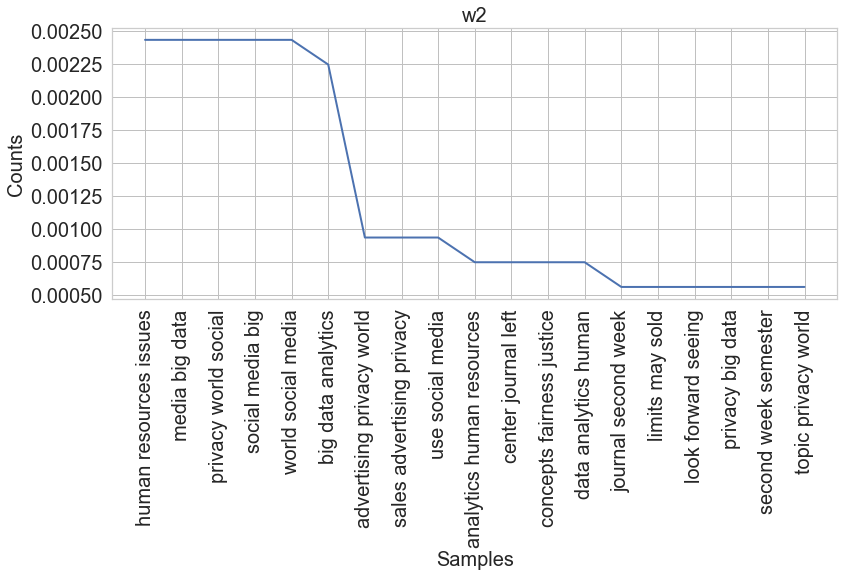

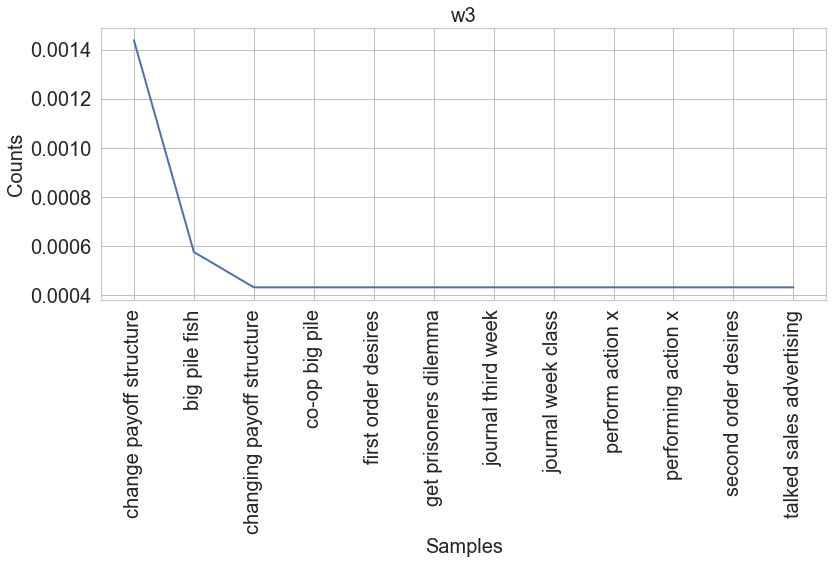

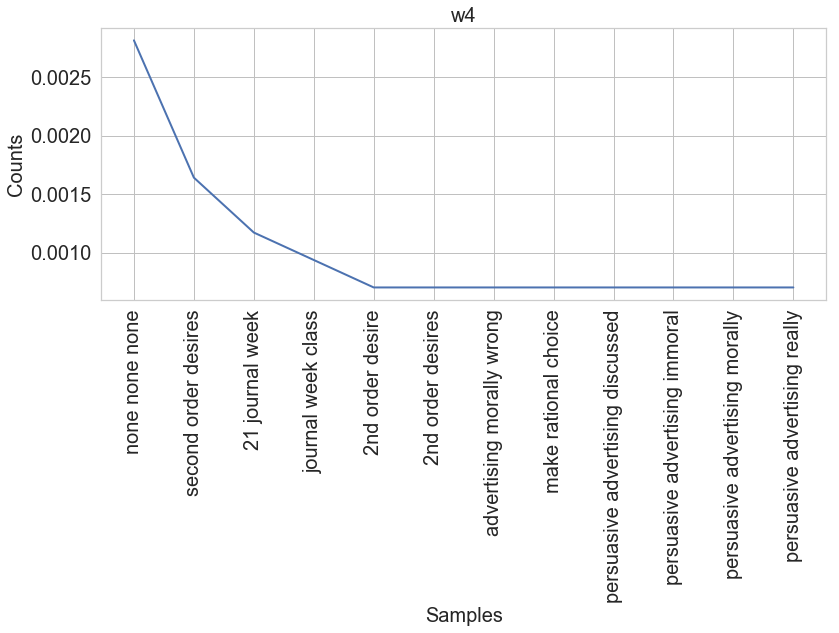

/Users/adam/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/tight_layout.py:182: UserWarning: The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The bottom and top margins cannot be made large '


In [23]:
trigrams = {}
week_iter = week_key_gen()
i = START_WEEK

while True:
    try:
        w = next(week_iter)
        
        bg = TrigramGetter()
        bg.process(combined[w])
        #store the trigram object in our dict
        trigrams[w] = bg

        # reshape into a usable form for plotting
        fs = FreqDist()
        for s, freq in bg.raw_freq:
            # make the string key and set the frequency
            fs["%s %s %s" % (s[0], s[1], s[2])] = freq

        # plot the cumulative frequencies
        draw_cumulative_freq({w : fs}, i)
        i += 1
    except StopIteration:
        break

In [24]:
clearplot_function()

In [28]:
print_top_likelihood_ratios(trigrams)

w2
('social', 'media', 'big')
('world', 'social', 'media')
('human', 'resources', 'issues')
('use', 'social', 'media')
('big', 'data', 'analytics')
('media', 'big', 'data')
('analytics', 'human', 'resources')
('privacy', 'world', 'social')
('privacy', 'big', 'data')
('sales', 'advertising', 'privacy')
w3
('change', 'payoff', 'structure')
('changing', 'payoff', 'structure')
('journal', 'week', 'class')
('performing', 'action', 'x')
('perform', 'action', 'x')
('get', 'prisoners', 'dilemma')
('second', 'order', 'desires')
('first', 'order', 'desires')
('big', 'pile', 'fish')
('talked', 'sales', 'advertising')
w4
('persuasive', 'advertising', 'morally')
('persuasive', 'advertising', 'immoral')
('persuasive', 'advertising', 'discussed')
('persuasive', 'advertising', 'really')
('none', 'none', 'none')
('21', 'journal', 'week')
('second', 'order', 'desires')
('journal', 'week', 'class')
('2nd', 'order', 'desires')
('2nd', 'order', 'desire')


In [32]:
print_top_PMI(trigrams)

Top PMI
w2
('concepts', 'fairness', 'justice')
('limits', 'may', 'sold')
('big', 'data', 'analytics')
('look', 'forward', 'seeing')
('human', 'resources', 'issues')
('center', 'journal', 'left')
('media', 'big', 'data')
('data', 'analytics', 'human')
('privacy', 'world', 'social')
('social', 'media', 'big')
w3
('perform', 'action', 'x')
('co-op', 'big', 'pile')
('performing', 'action', 'x')
('big', 'pile', 'fish')
('changing', 'payoff', 'structure')
('change', 'payoff', 'structure')
('second', 'order', 'desires')
('first', 'order', 'desires')
('get', 'prisoners', 'dilemma')
('journal', 'third', 'week')
w4
('21', 'journal', 'week')
('advertising', 'morally', 'wrong')
('make', 'rational', 'choice')
('second', 'order', 'desires')
('2nd', 'order', 'desire')
('2nd', 'order', 'desires')
('none', 'none', 'none')
('persuasive', 'advertising', 'morally')
('journal', 'week', 'class')
('persuasive', 'advertising', 'immoral')
